In [1]:
%matplotlib notebook
import imagej
from pathlib import Path
import os

import multiscale.LINK_system.coordinate as coord
import multiscale.ultrasound.reconstruction as recon
import multiscale.itk.transform as tran
import multiscale.itk.registration as reg
import multiscale.itk.itk_plotting as iplt

# Stitch ultrasound using ImageJ

In [2]:
data_dir = Path(Path.home(), r'Box\PyImageJ paper')
ij_path = str(Path(data_dir, 'Fiji.app'))

In [3]:
ij = imagej.init(ij_path, headless=False)

Added 383 JARs to the Java classpath.



Define the location of files needed for the analysis

In [4]:
# Temporary cell until we update ij with window
from jnius import autoclass
WindowManager = autoclass('ij.WindowManager')
ij.window = WindowManager

# Not temporary stuff
mat_dir = Path(data_dir, r'L38 Fiducial Z13115\Run-1')
intermediate_save_dir = Path(data_dir, r'L38 Fiducial Z13115\Run-1 Intermediate')
output_dir = data_dir
pl_path = Path(data_dir, 'L38 Fiducial Z13115.pos')

Specify arguments for the stitching

In [5]:
fuse_args = {'downsampling': 3, 'fused_image': '[Display using ImageJ]'}
search_str = 'IQ.mat'
output_name = 'L38 fiducial Z13115.tif'
overwrite_dataset = True
overwrite_tif = True

For demonstration purposes, we are sending the stitched image into ImageJ and then extracting the result to numpy.  With another option, we could write this image to the file system and then read it in using Python.  That options is useful for very large images or batch analysis/processing.

In [6]:
assembler = recon.UltrasoundImageAssembler(mat_dir, output_dir, ij, pl_path=pl_path, 
                                           intermediate_save_dir=intermediate_save_dir, 
                                           fuse_args=fuse_args, search_str=search_str, output_name=output_name,
                                           overwrite_dataset=overwrite_dataset, overwrite_tif=overwrite_tif)

In [7]:
assembler.assemble_bmode_image()

Saving images into tif files
Defining dataset from C:\Users\mpinkert\Box\PyImageJ paper\L38 Fiducial Z13115\Run-1 Intermediate
Fusing dataset from C:\Users\mpinkert\Box\PyImageJ paper\L38 Fiducial Z13115\Run-1 Intermediate\dataset.xml


Adjust the brightness/contrast and set the image slice to get the image in the paper.

In [8]:
ij.py.run_macro("""setMinAndMax(120.62, 170.62);
setSlice(236);""")

<org.scijava.script.ScriptModule at 0x1d519a480a0 jclass=org/scijava/script/ScriptModule jself=<LocalRef obj=0x44ed5280 at 0x1d51e835d30>>

Convert the ImageJ1 image into a numpy array

In [9]:
us_ij = ij.window.getCurrentImage()
us_array = ij.py.from_java(us_ij)

Get the voxel size of the ultrasound image

In [10]:
axialRes = us_ij.getCalibration().pixelHeight
lateralRes = us_ij.getCalibration().pixelWidth
elevationRes = us_ij.getCalibration().pixelDepth
us_spacing = [lateralRes, elevationRes, axialRes]

Close the ImageJ1 windows as they are no longer necessary

In [11]:
ij.window.closeAllWindows()

True

# Register ultrasound and microscopy using SimpleITK

## Image opening
Define the ultrasound image coordinate system using the multiscale-imaging python package.  Open the pre-stitched microscopy image into its own coordinate system.

In [12]:
# This opens a microscopy image stitched using the Grid/Collection stitching algorith
mpm_path = Path(data_dir, r'L38 Fiducial MPM Down4x.tif')

# This points to a file that contains the origins of the stitched image
mpm_origin_path = Path(data_dir, r'L38 Fiducial MPM settings.ome.tif')

# This is an externally measured variable that comes from an indicator gauge and gives the Z/Axial coordinate location
us_height = 13115

# This points to the settings of the US acquisition for coordinate definition
us_param_path = Path(mat_dir, r'L38 fiducial Z' + str(us_height) + '_Run-1_Settings.mat')

# This specifies what dynamic range to open the US image in as dB
dynamic_range = 50

In [13]:
mpm_image = coord.open_microscopy(mpm_path, mpm_origin_path, downsample_factor=4)

In [14]:
us_image = coord.convert_array_to_us(us_array, pl_path, us_param_path, us_spacing, us_height, dynamic_range)

## Acquire points
Use the manual landmark specification to get like points.  This registration uses the "shadow" of the object at the bottom of the ultrasound image.

<IPython.core.display.Javascript object>


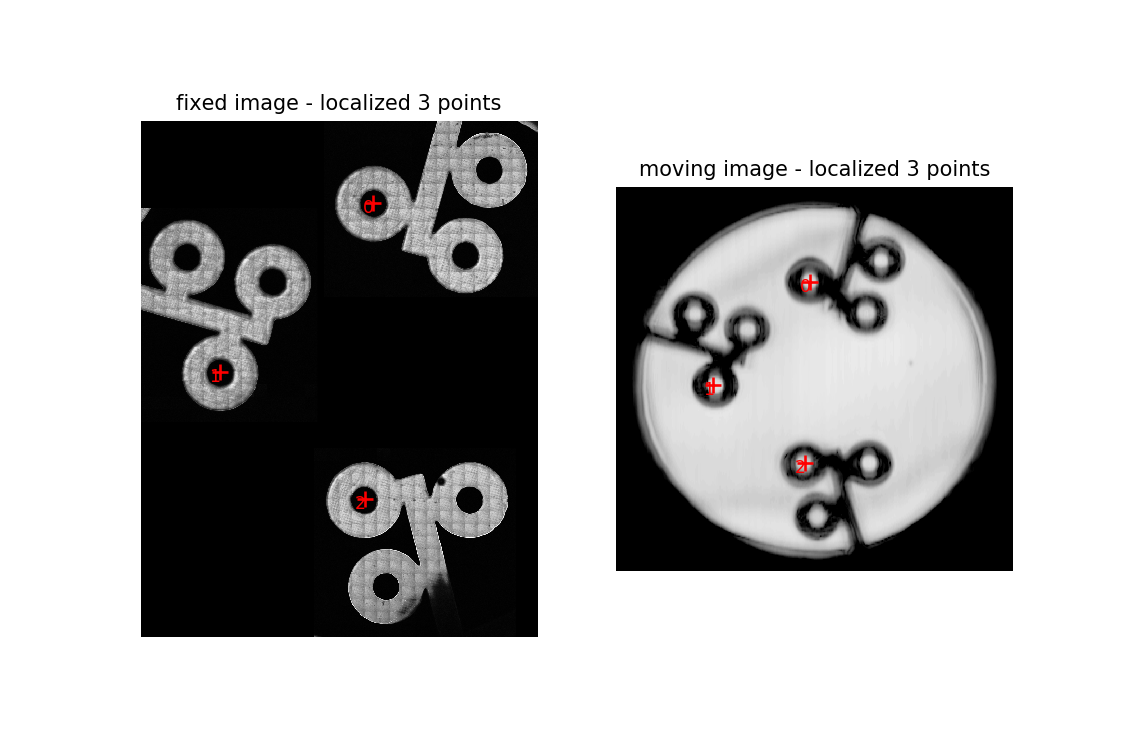

In [15]:
point_interface = iplt.RegistrationPointDataAcquisition(mpm_image, us_image)

In [16]:
transform = tran.landmarks_to_translation(point_interface)

## Register and plot overlay
Register the two images and then plot an overlay of the ultrasound image in the multiphoton coordinate system.

In [17]:
final_transform, metric, stop = reg.register(mpm_image, us_image, initial_transform=transform)

<IPython.core.display.Javascript object>


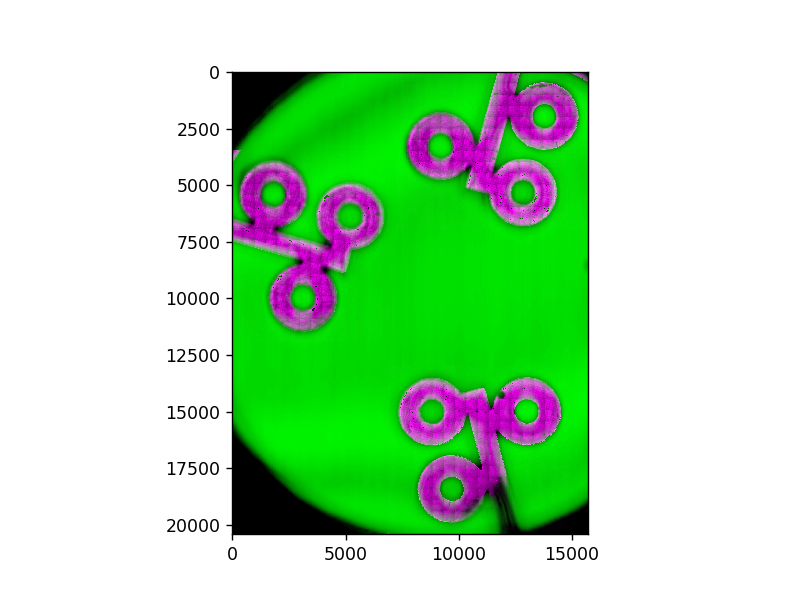

In [18]:
iplt.plot_overlay(mpm_image, us_image, final_transform, downsample=False, slice=1)